In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 13.1.0


# RCS of a 5 m x 5 m Plate

## Introduction

Radar Cross Section (RCS) is a fundamental concept in radar technology and electromagnetic scattering. It refers to the measure of an object's ability to reflect radar signals back to the radar receiver, often expressed in square meters (m²). Here's a brief introduction to RCS:

1. **Definition:** Radar Cross Section quantifies how detectable an object is by radar systems. It represents the effective area that the object presents to an incident radar signal, indicating how much of that signal is scattered back towards the radar receiver.

2. **Physical Characteristics:** The RCS of an object depends on its size, shape, material composition, and orientation relative to the radar. Objects with larger physical dimensions, specific shapes, and certain materials can have significantly different RCS values.

3. **Frequency Dependency:** RCS is frequency-dependent, meaning that an object's radar visibility can vary depending on the radar's operating frequency. Different frequencies interact with objects in distinct ways, leading to variations in RCS.

4. **Applications:** RCS plays a crucial role in military and civilian radar applications. In military contexts, understanding an aircraft or ship's RCS helps in stealth design to reduce detectability. In civilian applications, RCS is essential for radar systems to accurately detect and track objects like aircraft, ships, and automobiles.

5. **Measurement:** RCS is often measured in controlled environments using specialized test ranges, such as anechoic chambers or outdoor radar cross-section measurement facilities. These measurements provide valuable data for radar system development and validation.

6. **Stealth Technology:** Reducing an object's RCS is a key aspect of stealth technology, making military assets less visible to radar. This involves shaping the object to minimize radar reflections and using radar-absorbing materials.

7. **Countermeasures:** Understanding RCS helps in the development of radar countermeasures and electronic warfare techniques. These tactics aim to deceive or jam radar systems by manipulating RCS signatures.

In summary, Radar Cross Section is a critical concept in radar technology, influencing the design of radar systems, military stealth technology, and the development of countermeasures. It plays a pivotal role in the ability to detect, identify, and track objects using radar.

[`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) integrates ray tracing and the Physical Optics (PO) approximation to model the Radar Cross Section (RCS) of three-dimensional objects. In this example, we showcase how the [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) framework can be used to calculate the RCS of a flat plate across various observation angles.

## 3D Model

[`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) leverages PyMeshLab for 3D model processing. This means that any 3D model format supported by PyMeshLab can seamlessly integrate with [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/).

Firstly, get the path of the model.


In [2]:
import pymeshlab
import numpy as np

model_path = "../models/plate5x5.stl"

_Plot the model_


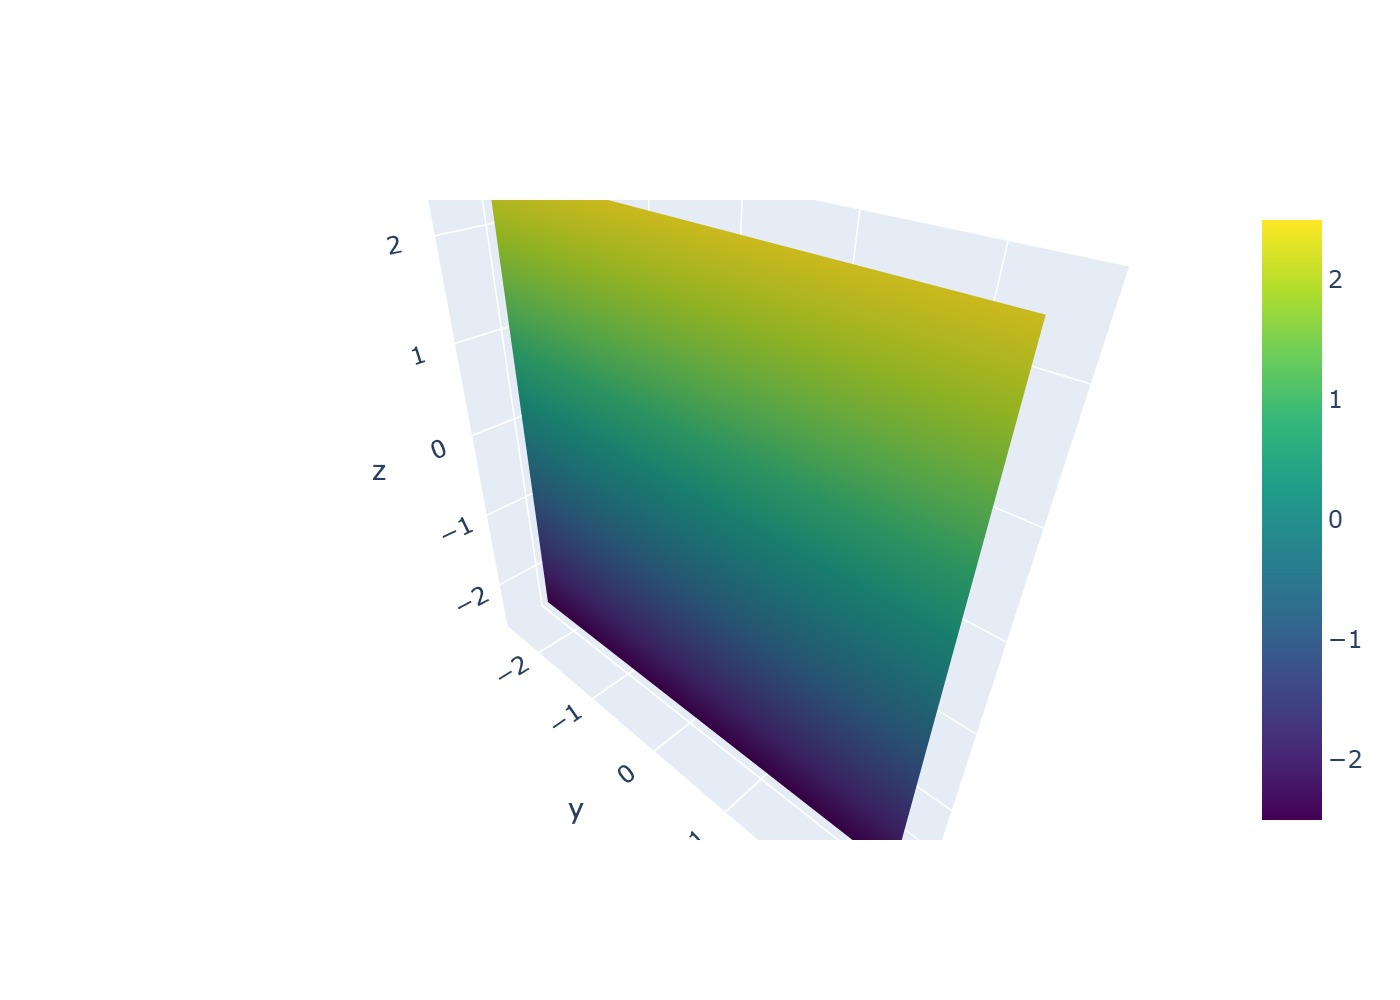

In [3]:
import plotly.graph_objs as go
from IPython.display import Image

ms = pymeshlab.MeshSet()
ms.load_new_mesh(model_path)
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())

fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],
        y=v_matrix[:, 1],
        z=v_matrix[:, 2],
        i=f_matrix[:, 0],
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],
        colorscale="Viridis",
    )
)
fig["layout"]["scene"]["aspectmode"] = "data"
fig["layout"]["height"] = 800

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Monostatic

Incident angle and observation angle are the same


In [4]:
import time
from radarsimpy.simulator import sim_rcs

phi = np.arange(-90, 90, 0.5)
theta = np.zeros_like(phi) + 90
freq = 1e9
pol = [0, 0, 1]
density = 4

target_pec = {
    "model": model_path,
    "unit": "m",
    "location": (0, 0, 0),
}

target_glass = {
    "model": model_path,
    "unit": "m",
    "location": (0, 0, 0),
    "permittivity": 5,
}

tic = time.time()

rcs_pec = 10 * np.log10(
    sim_rcs([target_pec], freq, phi, theta, pol, density=density) + 0.000001
)

rcs_glass = 10 * np.log10(
    sim_rcs([target_glass], freq, phi, theta, pol, density=density) + 0.000001
)

toc = time.time()

print("Exec time :" + str(toc - tic) + "s")

Exec time :1.695965051651001s


_Plot_


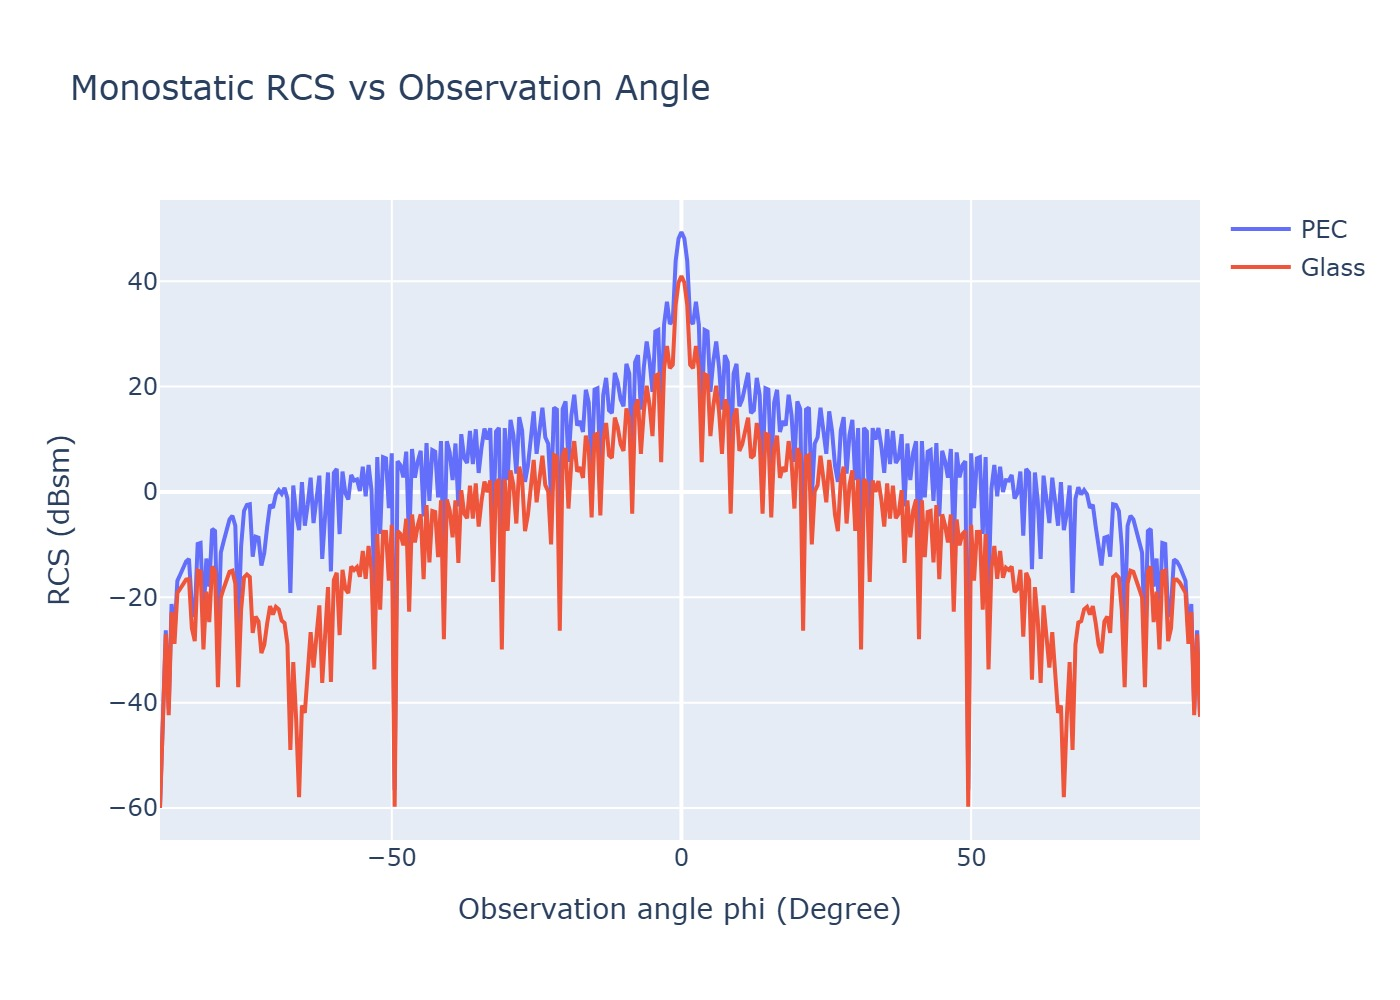

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=phi, y=rcs_pec, name="PEC"))
fig.add_trace(go.Scatter(x=phi, y=rcs_glass, name="Glass"))
fig.update_layout(
    title="Monostatic RCS vs Observation Angle",
    yaxis=dict(title="RCS (dBsm)"),
    xaxis=dict(title="Observation angle phi (Degree)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Bistatic

Incident angle and observation angle are different


In [6]:
obs_phi = np.arange(-90, 90, 0.5)
obs_theta = 90
freq = 1e9
pol = [0, 1, 0]
density = 1

rcs_vpol = np.zeros_like(obs_phi)
rcs_hpol = np.zeros_like(obs_phi)

inc_phi = 45
inc_theta = 90

target_pec = {
    "model": model_path,
    "location": (0, 0, 0),
}

tic = time.time()
for phi_idx, phi_ang in enumerate(obs_phi):
    rcs_vpol[phi_idx] = 10 * np.log10(
        sim_rcs(
            [target_pec],
            freq,
            inc_phi=inc_phi,
            inc_theta=inc_theta,
            inc_pol=[0, 0, 1],
            obs_phi=phi_ang,
            obs_theta=obs_theta,
            density=density,
        )
        + 0.0000001
    )
    rcs_hpol[phi_idx] = 10 * np.log10(
        sim_rcs(
            [target_pec],
            freq,
            inc_phi=inc_phi,
            inc_theta=inc_theta,
            inc_pol=[0, 1, 0],
            obs_phi=phi_ang,
            obs_theta=obs_theta,
            density=density,
        )
        + 0.0000001
    )
toc = time.time()
print("Exec time :" + str(toc - tic) + "s")

Exec time :2.767573833465576s


_Plot_


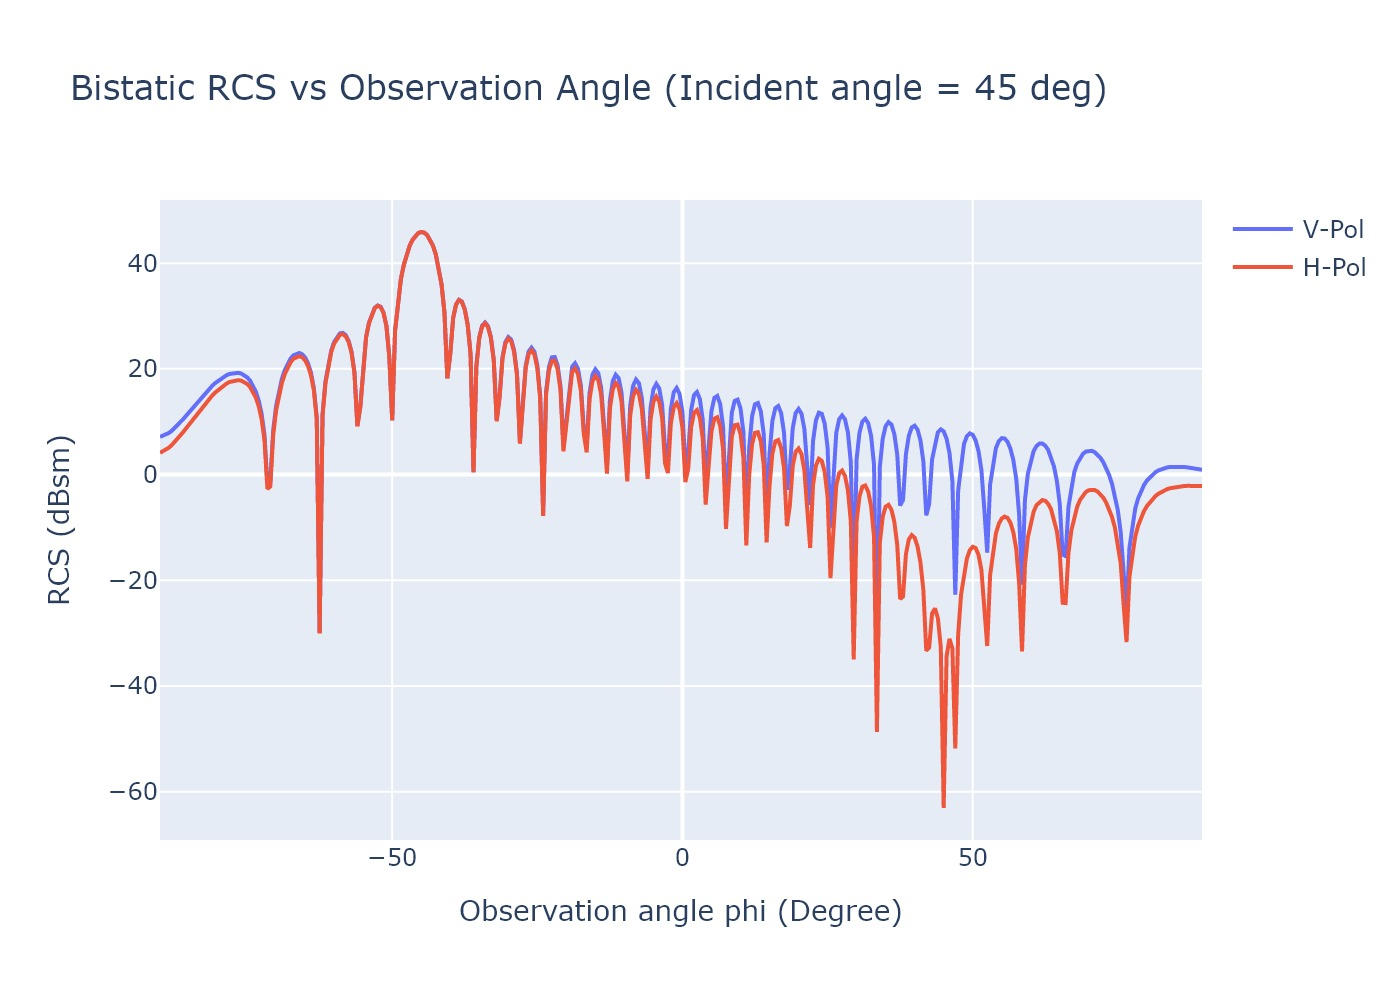

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=obs_phi, y=rcs_vpol, name="V-Pol"))
fig.add_trace(go.Scatter(x=obs_phi, y=rcs_hpol, name="H-Pol"))

fig.update_layout(
    title="Bistatic RCS vs Observation Angle (Incident angle = 45 deg)",
    yaxis=dict(title="RCS (dBsm)"),
    xaxis=dict(title="Observation angle phi (Degree)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))